<a href="https://colab.research.google.com/github/stochasticats/plantpathologyfgvc7-keras-deeplearning/blob/master/plantpathologyfgvc7_deeplearning_custommodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plant Pathology 2020 - FGVC7
Identify the category of foliar diseases in apple trees

Kaggle competition - https://www.kaggle.com/c/plant-pathology-2020-fgvc7/submit

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
print(tf.__version__)
import os
import shutil
import matplotlib.pyplot as plt

2.2.0-rc1


#Loading Data and Preprocessing.
Here we load the data and take a look at what we're dealing with.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!unzip -uq "/content/drive/My Drive/plant-pathology-2020-fgvc7.zip"

In [0]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

targets = train_df[['healthy', 'multiple_diseases', 'rust', 'scab']]

In [5]:
print("Shape of train data: " + str(train_df.shape))
print("Shape of test data: " + str(test_df.shape))

Shape of train data: (1821, 5)
Shape of test data: (1821, 1)


In [6]:
train_len = train_df.shape[0]
test_len = test_df.shape[0]
print(train_len)
print(test_len) 

1821
1821


Let's see the distribution of images in terms of the targets/labels.

In [7]:
print(train_df.describe())
print(test_df.describe())

           healthy  multiple_diseases         rust         scab
count  1821.000000        1821.000000  1821.000000  1821.000000
mean      0.283361           0.049973     0.341571     0.325096
std       0.450754           0.217948     0.474367     0.468539
min       0.000000           0.000000     0.000000     0.000000
25%       0.000000           0.000000     0.000000     0.000000
50%       0.000000           0.000000     0.000000     0.000000
75%       1.000000           0.000000     1.000000     1.000000
max       1.000000           1.000000     1.000000     1.000000
         image_id
count        1821
unique       1821
top     Test_1269
freq            1


Ah, we see the multiple_diseases label has drastically less images than the rest of the labels. Once we load the images in raw data form, we'll use scikitlearn to randomly over sample so we can fix this class imbalance.

Now let's load the image data.

In [8]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from tqdm.notebook import tqdm

path = '/content/images/'
num_img = train_df.shape[0]
size = 224
train_images = np.ndarray(shape=(train_len, size, size, 3))
for i in tqdm(range(num_img)):
  img = load_img(path + f'Train_{i}.jpg', target_size=(size, size))
  train_images[i] = np.float32(img_to_array(img))

test_images = np.ndarray(shape=(test_len, size, size, 3))
for i in tqdm(range(num_img)):
  img = load_img(path + f'Test_{i}.jpg', target_size=(size, size))
  test_images[i] = np.float32(img_to_array(img))

Using TensorFlow backend.


In [9]:
print(train_images.shape)
print(test_images.shape)

(1821, 224, 224, 3)
(1821, 224, 224, 3)


Here we see the images are in raw data form, with three matrices for RGB format. We'll rescale later on as well.

In [10]:
print(train_images[1])
print(train_images[1].shape)

[[[207. 219. 219.]
  [217. 228. 234.]
  [224. 234. 244.]
  ...
  [231. 255. 255.]
  [229. 255. 254.]
  [227. 250. 255.]]

 [[209. 221. 221.]
  [219. 230. 236.]
  [225. 235. 245.]
  ...
  [238. 255. 255.]
  [237. 255. 255.]
  [229. 253. 255.]]

 [[211. 223. 223.]
  [219. 230. 236.]
  [225. 235. 245.]
  ...
  [243. 255. 255.]
  [244. 255. 255.]
  [231. 255. 255.]]

 ...

 [[211. 211. 147.]
  [215. 216. 148.]
  [219. 217. 143.]
  ...
  [ 77. 113.  77.]
  [ 73. 110.  76.]
  [ 72. 109.  78.]]

 [[215. 212. 145.]
  [219. 216. 145.]
  [221. 219. 145.]
  ...
  [ 87. 123.  85.]
  [ 75. 116.  82.]
  [ 68. 109.  79.]]

 [[214. 214. 144.]
  [220. 216. 143.]
  [222. 219. 142.]
  ...
  [ 75. 114.  87.]
  [ 74. 111.  78.]
  [ 77. 115.  78.]]]
(224, 224, 3)


Let's take a look at what the images look like.

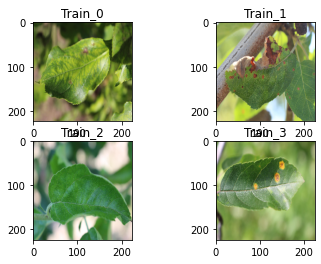

In [11]:
for i in range(4):
	plt.subplot(220 + 1 + i)
	plt.title(train_df['image_id'][i])
	plt.imshow(np.uint8(train_images[i]))
plt.show()

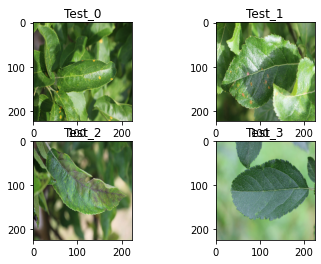

In [12]:
for i in range(4):
	plt.subplot(220 + 1 + i)
	plt.title(test_df['image_id'][i])
	plt.imshow(np.uint8(test_images[i]))
plt.show()

Now let's fix the class imbalance with RandomOverSampler. This will add more images to the multiple_diseases class.

In [14]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
x_res, y_res = ros.fit_resample(np.reshape(train_images, (-1, size * size * 3)), targets.to_numpy())
x_res = x_res.reshape((-1, size, size, 3))

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [15]:
print(x_res.shape)
print(y_res.shape)

(2488, 224, 224, 3)
(2488, 4)


In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_images, targets.to_numpy(), test_size=0.1)

In [14]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1638, 224, 224, 3)
(183, 224, 224, 3)
(1638, 4)
(183, 4)


Now we prepare the data for going into a Keras deep learning model. Here I use the ImageDataGenerator to also give us more images by using the parameters to rotate, horizontally flip, and vertically flip. Also the image is rescaled by 1/255 to normalize the raw data so that the activation functions work properly.

In [0]:
from keras_preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
	    rotation_range=40,
      zoom_range=0.2,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow(
    x = x_train, 
    y = y_train,
    batch_size = 32
    )

validation_generator = validation_datagen.flow(
    x = x_test,
    y = y_test,
    batch_size = 32
    )

# Model
Let's create the model. Here I build a custom model consisting of convolution layers of ascending filter size, a flatten, and 2 dense layers with the last activation function being the softmax so we can predict between four classes.

In [16]:
def create_model():
  model = tf.keras.Sequential([
      # This is the first convolution
      tf.keras.layers.Conv2D(32, (3,3), input_shape=(size, size, 3), activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
      # The second convolution
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
      # Third conv layer
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
      # Fourth conv layer
      tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
      # Fifth conv layer
      tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
      # Flatten the results and send to softmax
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.4),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dense(4, activation='softmax')
      ])
  
  adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

  model.compile(
        loss = 'kullback_leibler_divergence', 
        optimizer = adam, 
        metrics = ['accuracy'])
  return model

model = create_model()

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 222, 222, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 108, 108, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 108, 108, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 51, 51, 128)       7

In [17]:
epochs = 30
batch_size = 32
steps_per_epoch = x_train.shape[0] // 32
print(steps_per_epoch)

51


Now that we've built the model and set up our model parameters, let's train it and see what happens!

In [18]:
history = model.fit(
    x = train_generator,  
    validation_data = validation_generator,
    batch_size = batch_size,
    epochs = epochs,
    steps_per_epoch = steps_per_epoch,
    validation_steps = steps_per_epoch,
    verbose=1)

Epoch 1/30
51/51 [==============================] - 20s 402ms/step - loss: 1.9108 - accuracy: 0.4412 - val_loss: 1.9780 - val_accuracy: 0.2929
Epoch 2/30
51/51 [==============================] - 20s 387ms/step - loss: 1.3083 - accuracy: 0.5174 - val_loss: 3.3986 - val_accuracy: 0.2914
Epoch 3/30
51/51 [==============================] - 20s 391ms/step - loss: 1.0958 - accuracy: 0.5872 - val_loss: 5.9116 - val_accuracy: 0.2853
Epoch 4/30
51/51 [==============================] - 20s 388ms/step - loss: 0.9622 - accuracy: 0.6146 - val_loss: 7.8840 - val_accuracy: 0.2897
Epoch 5/30
51/51 [==============================] - 20s 387ms/step - loss: 0.8116 - accuracy: 0.6912 - val_loss: 7.7776 - val_accuracy: 0.2888
Epoch 6/30
51/51 [==============================] - 20s 386ms/step - loss: 0.7567 - accuracy: 0.7167 - val_loss: 8.2336 - val_accuracy: 0.2897
Epoch 7/30
51/51 [==============================] - 20s 385ms/step - loss: 0.6396 - accuracy: 0.7646 - val_loss: 6.8612 - val_accuracy: 0.2878

# Results
We plot the train and validation accuracy and loss to see how the model did over the epochs.

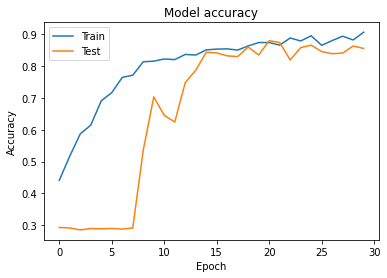

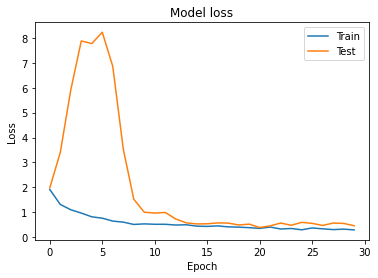

In [19]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Let's look at the last accuracy rate in terms of error.

In [20]:
train_err = (1-history.history['accuracy'][-1])*100
validation_err = (1-history.history['val_accuracy'][-1])*100
print("Train error " + str(train_err))
print("Validation error " + str(validation_err))

Train error 9.33997631072998
Validation error 14.423078298568726


#Prediction
Here we feed the test image set into the model.predict function and see how our model does.

In [21]:
probabilities = model.predict(test_images)
print(probabilities)
print(probabilities[:,0].mean())
print(probabilities[:,1].mean())
print(probabilities[:,2].mean())
print(probabilities[:,3].mean())

[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 ...
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]
0.002746006
0.0
0.997254
0.0


In [0]:
test = pd.read_csv('test.csv')
res = pd.DataFrame()
res['image_id'] = test['image_id']
res['healthy'] = probabilities[:, 0]
res['multiple_diseases'] = probabilities[:, 1]
res['rust'] = probabilities[:, 2]
res['scab'] = probabilities[:, 3]

In [0]:
res.to_csv('submission.csv', index=False)